# 안녕하세요^^ 
# AIVLE 미니 프로젝트에 오신 여러분을 환영합니다.
* 본 과정에서는 실제 사례와 데이터를 기반으로 문제를 해결하는 전체 과정을 자기 주도형 실습으로 진행해볼 예정입니다.
* 앞선 교육과정을 정리하는 마음과 지금까지 배운 내용을 바탕으로 문제 해결을 해볼게요!
* 미니 프로젝트를 통한 문제 해결 과정 'A에서 Z까지', 지금부터 시작합니다!

---

In [ ]:
# 필요 라이브러리부터 설치할께요.
!pip install pandas seaborn sklearn

---

---

# 1. 라이브러리 Import 및 데이터 불러오기

* sklearn 을 설치 하세요. 

* 관련 라이브러리들을 불러오세요

In [1]:
import numpy as np
import pandas as pd

# 학습/평가 데이터 로딩
df_21_feature = pd.read_csv("train_x.csv")
df_21_target = pd.read_csv("train_y.csv")
df_22_feature = pd.read_csv("test_x.csv")
df_22_target = pd.read_csv("test_y.csv")

#### [실습문제1] 라이브러리 불러오기



In [2]:
# 아래에 실습코드를 작성하세요.
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import *
import pickle

import warnings
warnings.filterwarnings('ignore')

In [3]:
# 시각화 한글폰트 설정

plt.rc('font', family='Malgun Gothic')
sns.set(font="Malgun Gothic",#"NanumGothicCoding", 
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')

In [4]:
def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df.reset_index(drop=True, inplace = True)

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.grid()

    return fi_df

---

# 2. Modeling
## 이제 모델링을 해봅시다!
+ KeyPoint : 머신러닝 라이브러리를 토대로 모델링을 할 수 있다.

### 가. LinearRegression 부터 시작해봅시다.

#### [실습문제2] 머신러닝_1
* Train과 Test로 나눈 데이터를 기준으로 LinearRegression 모델링을 진행하고 평가를 해주세요.
* 그리고 모델 파일을 pkl로 저장해주세요.
* 성능지표 : RMSE, R-squared Score(소수점 5째자리까지, 반올림)

In [5]:
# 아래에 실습코드를 작성하세요.
from sklearn.linear_model import LinearRegression

m1 = LinearRegression()
m1.fit(df_21_feature, df_21_target)
p1 = m1.predict(df_22_feature)

In [6]:
# Test 데이터로 성능을 평가해보세요.
print(f'R-squared Score: {r2_score(df_22_target, p1): .5f}')
print(f'RMSE: {mean_squared_error(df_22_target, p1): .5f}')

R-squared Score:  0.92543
RMSE:  41.05523


In [7]:
# 학습한 모델을 파일로 저장해보세요.
pickle.dump(m1, open('./models/lr_model.pkl', 'wb'))

In [8]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

def forward_stepwise_linear(x_train, y_train):

    # 변수목록, 선택된 변수 목록, 단계별 모델과 AIC 저장소 정의
    features = list(x_train)
    selected = []
    step_df = pd.DataFrame({ 'step':[], 'feature':[],'aic':[]})

    for s in range(0, len(features)) :
        result =  { 'step':[], 'feature':[],'aic':[]}

        # 변수 목록에서 변수 한개씩 뽑아서 모델에 추가
        for f in features :
            vars = selected + [f]
            x_tr = x_train[vars]
            model = OLS(y_train, add_constant(x_tr)).fit()
            result['step'].append(s+1)
            result['feature'].append(vars)
            result['aic'].append(model.aic)
        
        # 모델별 aic 집계
        temp = pd.DataFrame(result).sort_values('aic').reset_index(drop = True)

        # 만약 이전 aic보다 새로운 aic 가 크다면 멈추기
        if step_df['aic'].min() < temp['aic'].min() :
            break
        step_df = pd.concat([step_df, temp], axis = 0).reset_index(drop = True)

        # 선택된 변수 제거
        v = temp.loc[0,'feature'][s]
        features.remove(v)

        selected.append(v)
    
    # 선택된 변수와 step_df 결과 반환
    return selected, step_df

In [10]:
cols, _ = forward_stepwise_linear(df_21_feature, df_21_target)
print(cols)

['PM10', '시정(10m)', 'CO', 'PM25', '지면온도(°C)', '30cm 지중온도(°C)', '전운량(10분위)', '5cm 지중온도(°C)', '10cm 지중온도(°C)', 'NO2']


In [11]:
xtrain = df_21_feature[cols]
xtest = df_22_feature[cols]

model = LinearRegression()
model.fit(xtrain, df_21_target)
pred = model.predict(xtest)

In [12]:
# Test 데이터로 성능을 평가해보세요.
print(f'R-squared Score: {r2_score(df_22_target, pred): .5f}')
print(f'RMSE: {mean_squared_error(df_22_target, pred): .5f}')

R-squared Score:  0.92549
RMSE:  41.02437


### 나. 다음은 앙상블 기법을 토대로 랜덤포레스트와 그라디언브스팅을 활용해봅시다.

#### 1) 렌덤포레스트
##### 배깅의 일종으로 의사결정나무(Decision Tree) 여러 개를 모아서 숲을 랜덤으로 구성하고 이를 종합해서 최종 모델을 산출하는 기법이라고 할 수 있다.

#### [실습문제3] 머신러닝_2
* Train과 Test로 나눈 데이터를 기준으로 렌덤포레스트로 모델을 학습을 진행하고 평가를 해주세요.
* 그리고 모델 파일을 pkl로 저장해주세요.
* 성능지표 : RMSE, R-squared Score(소수점 5째자리까지, 반올림)

In [8]:
# 아래에 실습코드를 작성하세요.
from sklearn.ensemble import RandomForestRegressor

m2 = RandomForestRegressor()
m2.fit(df_21_feature, df_21_target)
p2 = m2.predict(df_22_feature)

In [9]:
# Test 데이터로 성능을 평가해보세요.
print(f'R-squared Score: {r2_score(df_22_target, p2): .5f}')
print(f'RMSE: {mean_squared_error(df_22_target, p2): .5f}')

R-squared Score:  0.91667
RMSE:  45.87855


In [10]:
# 학습한 모델을 파일로 저장해보세요.
pickle.dump(m2, open('./models/rf_model.pkl', 'wb'))

#### [실습문제4] 머신러닝_3
* 렌덤포레스트로 학습한 모델의 feature_importances 또는 Shap value를 구해보세요.
* 확인할 수 있는 내용으로 우리 모델에서의 인사이트를 정리해보세요.

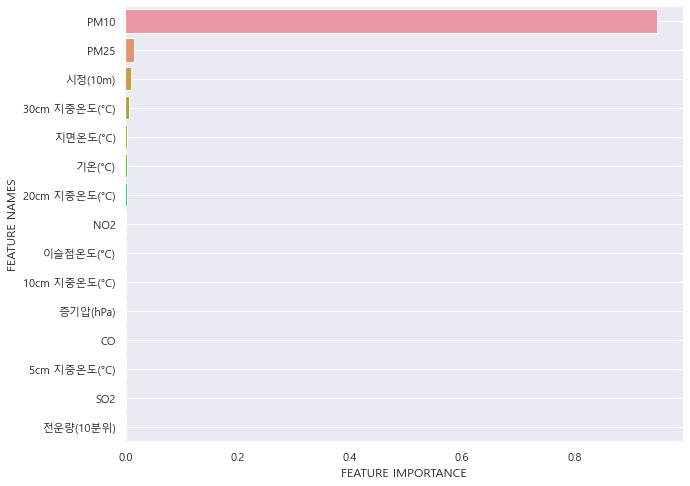

In [11]:
# Feature의 중요도 확인
result = plot_feature_importance(m2.feature_importances_, list(df_21_feature))

In [12]:
# 확인할 수 있는 인사이트
# 1.
# 2.
# 3.

#### 2) GradientBoosting
##### 앞선 모델의 에러를 다음 모델의 예측 값으로 활용하면서 가중치 업데이트 하는데 경사하강법(Gradient Descent)를 활용해서 최적 모델을 만드는 기법

#### [실습문제5] 머신러닝_4
* Train과 Test로 나눈 데이터를 기준으로 그라디언트부스팅으로 모델을 학습을 진행하고 평가를 해주세요.
* 그리고 모델 파일을 pkl로 저장해주세요.
* 성능지표 : RMSE, R-squared Score(소수점 5째자리까지, 반올림)

In [13]:
# 아래에 실습코드를 작성하세요.
from xgboost import XGBRegressor

m3 = XGBRegressor()
m3.fit(df_21_feature, df_21_target)
p3 = m3.predict(df_22_feature)

In [14]:
# Test 데이터로 성능을 평가해보세요.
print(f'R-squared Score: {r2_score(df_22_target, p3): .5f}')
print(f'RMSE: {mean_squared_error(df_22_target, p3): .5f}')

R-squared Score:  0.90356
RMSE:  53.09498


In [15]:
# 학습한 모델을 파일로 저장해보세요.
pickle.dump(m3, open('./models/xgb_model.pkl', 'wb'))

#### [실습문제6] 머신러닝_5
* 그라디언트부스팅으로 학습한 모델의 feature_importances 또는 Shap value를 구해보세요.
* 확인할 수 있는 내용으로 우리 모델에서의 인사이트를 정리해보세요.

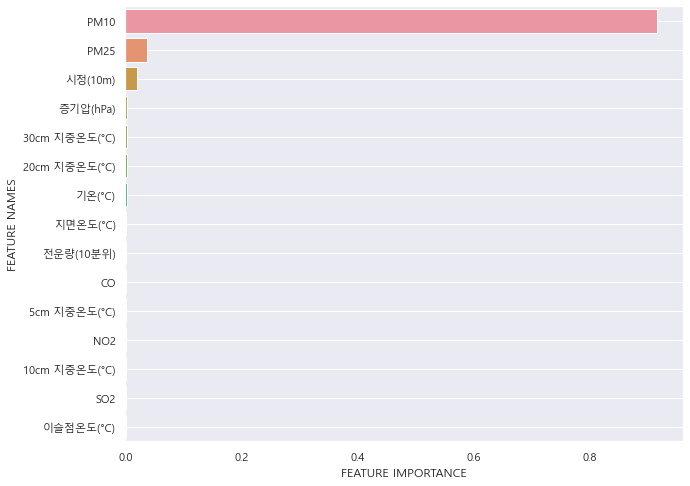

In [16]:
# Feature의 중요도 확인
result = plot_feature_importance(m3.feature_importances_, list(df_21_feature))

In [17]:
# 확인할 수 있는 인사이트
# 1.
# 2.
# 3.

#### 3) Self Choice Model
##### 앞선 교육과정에서 배운 머신러닝 모델 중 어떤 것이든 좋습니다. 원하는 모델을 선택해서 학습을 시켜보세요.

#### [실습문제7] 머신러닝_6
* Train과 Test로 나눈 데이터를 기준으로 Self Choice Model로 모델을 학습을 진행하고 평가를 해주세요.
* 그리고 모델 파일을 pkl로 저장해주세요.
* 성능지표 : RMSE, R-squared Score(소수점 5째자리까지, 반올림)

- LightGBM

In [21]:
# 아래에 실습코드를 작성하세요.
import lightgbm as lgb

params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learnnig_rage': 0.05,
    'metric': {'l2','l1'},
    # 'verbose': -1
}

train_data = lgb.Dataset(df_21_feature, df_21_target)
test_data = lgb.Dataset(df_22_feature, df_22_target, reference=train_data)

In [22]:
m4 = lgb.train(params, train_set=train_data, valid_sets=test_data, early_stopping_rounds=30)

[LightGBM] [Warning] Unknown parameter: learnnig_rage
[1]	valid_0's l1: 15.0041	valid_0's l2: 458.749
Training until validation scores don't improve for 30 rounds
[2]	valid_0's l1: 13.6442	valid_0's l2: 381.215
[3]	valid_0's l1: 12.4516	valid_0's l2: 317.495
[4]	valid_0's l1: 11.3615	valid_0's l2: 265.744
[5]	valid_0's l1: 10.401	valid_0's l2: 223.608
[6]	valid_0's l1: 9.54817	valid_0's l2: 189.118
[7]	valid_0's l1: 8.79979	valid_0's l2: 161.304
[8]	valid_0's l1: 8.10836	valid_0's l2: 138.364
[9]	valid_0's l1: 7.51682	valid_0's l2: 120.052
[10]	valid_0's l1: 7.00527	valid_0's l2: 105.26
[11]	valid_0's l1: 6.55036	valid_0's l2: 93.0066
[12]	valid_0's l1: 6.15885	valid_0's l2: 83.3065
[13]	valid_0's l1: 5.80768	valid_0's l2: 75.044
[14]	valid_0's l1: 5.52368	valid_0's l2: 68.7314
[15]	valid_0's l1: 5.28635	valid_0's l2: 63.5012
[16]	valid_0's l1: 5.06878	valid_0's l2: 59.1382
[17]	valid_0's l1: 4.89302	valid_0's l2: 55.8032
[18]	valid_0's l1: 4.74564	valid_0's l2: 52.9989
[19]	valid_0's 

In [23]:
p4 = m4.predict(df_22_feature)

In [24]:
# Test 데이터로 성능을 평가해보세요.
print(f'R-squared Score: {r2_score(df_22_target, p4): .5f}')
print(f'RMSE: {mean_squared_error(df_22_target, p4): .5f}')

R-squared Score:  0.93245
RMSE:  37.18955


In [25]:
# 학습한 모델을 파일로 저장해보세요.
pickle.dump(m4, open('./models/gbm_model.pkl', 'wb'))

- SARIMA

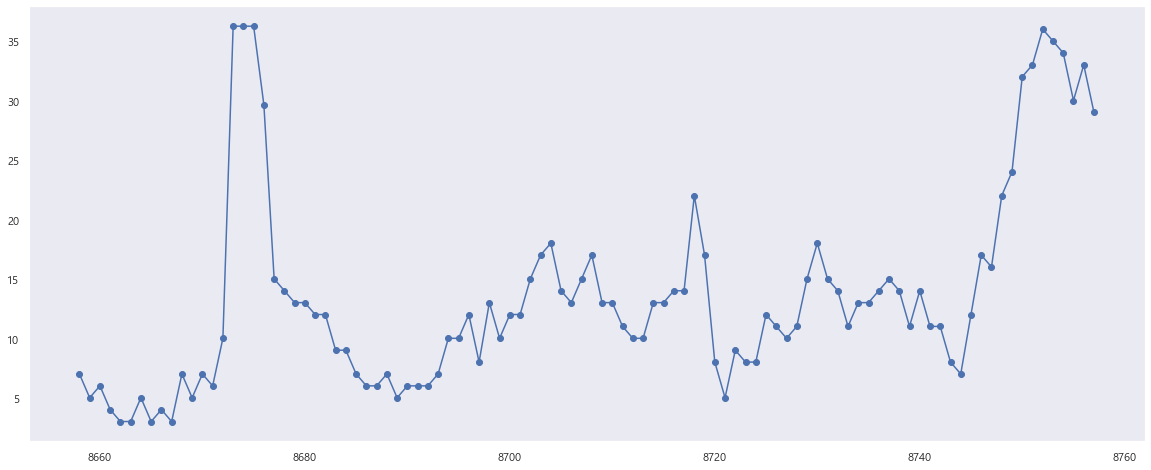

In [43]:
y = df_21_target[-100:]
plt.figure(figsize = (20,8))
plt.plot(y, marker ='o')
plt.grid()
plt.show()

In [37]:
# 아래에 실습코드를 작성하세요.
import statsmodels.api as sm

m5 = sm.tsa.SARIMAX(df_21_target, order=(4,1,3)).fit()
p5 = m5.forecast(30)

c:\Users\User\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [38]:
# Test 데이터로 성능을 평가해보세요.
tmp = df_22_target[:30]
print(f'R-squared Score: {r2_score(tmp, p5): .5f}')
print(f'RMSE: {mean_squared_error(tmp, p5): .5f}')

R-squared Score:  0.35264
RMSE:  28.86932


In [39]:
# 학습한 모델을 파일로 저장해보세요.
pickle.dump(m5, open('./models/sarimma_model.pkl', 'wb'))

In [34]:
from itertools import product

p = [1,2,3,4]
q = [1,2,3,4]
d = [1]
iter = list(product(p,d,q))

In [40]:
import warnings
warnings.filterwarnings('ignore')

In [41]:
rmse, aic = [],[]
for i in iter :
    model_fit = sm.tsa.SARIMAX(df_21_target, order=(i[0],i[1],i[2])).fit()
    pred = model_fit.forecast(30)
    rmse.append(mean_squared_error(tmp, pred))
    aic.append(model_fit.aic)
    print(i)

(1, 1, 1)
(1, 1, 2)
(1, 1, 3)
(1, 1, 4)
(2, 1, 1)
(2, 1, 2)
(2, 1, 3)
(2, 1, 4)
(3, 1, 1)
(3, 1, 2)
(3, 1, 3)
(3, 1, 4)
(4, 1, 1)
(4, 1, 2)
(4, 1, 3)
(4, 1, 4)


In [42]:
result = pd.DataFrame({'params(p,d,q)' : iter, 'rmse' : rmse, 'aic':aic})

display(result.loc[result['rmse'] == result.rmse.min()])
display(result.loc[result['aic'] == result.aic.min()])

,"params(p,d,q)",rmse,aic
13,"(4, 1, 2)",28.717726,61252.428824


,"params(p,d,q)",rmse,aic
7,"(2, 1, 4)",102.10479,61217.068491


#### [실습문제8] 머신러닝_7
* Self Choice Model로 학습한 모델의 feature_importances 또는 Shap value를 구해보세요.
* 확인할 수 있는 내용으로 우리 모델에서의 인사이트를 정리해보세요.

In [ ]:
# 확인할 수 있는 인사이트
# 1.
# 2.
# 3.